# Import package

In [1]:
import os
import math
import time 
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib
from collections import Counter

# Global variable

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
tf.device('/gpu:0')
print(device_lib.list_local_devices())
label_classes = ['森森', '牛排', '巧巧', '小白', '花捲', '黑胖', '乖狗', '橘子', '烏龜', '松鼠', '笨鳥']

num_of_class = len(label_classes)
batch_size = 32
target_size = (224, 224)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15005041316778588322
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1968491726
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8184693187392529020
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 3GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


# Preprocess data

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    # rotation_range=10,
    # shear_range=0.1,
    # zoom_range=0.1,
    # fill_mode='nearest'
)

# train
train_generator = train_datagen.flow_from_directory(
    directory="data/",
    target_size=target_size,
    color_mode="rgb",
    class_mode='categorical',
    classes=label_classes,
    batch_size=batch_size,
    shuffle=True,
    subset='training'
)

for i, j in Counter(train_generator.classes).items():
    print(f"{label_classes[i]} with {j:3d} images")
print()

# valid
valid_generator = train_datagen.flow_from_directory(
    directory="data/",
    target_size=target_size,
    color_mode="rgb",
    class_mode='categorical',
    classes=label_classes,
    batch_size=batch_size,
    shuffle=True,
    subset='validation'
)
for i, j in Counter(valid_generator.classes).items():
    print(f"{label_classes[i]} with {j:3d} images")
print()

Found 1214 images belonging to 11 classes.
森森 with 122 images
牛排 with 158 images
巧巧 with 163 images
小白 with 140 images
花捲 with  94 images
黑胖 with 117 images
乖狗 with 148 images
橘子 with 100 images
烏龜 with  79 images
松鼠 with  54 images
笨鳥 with  39 images

Found 296 images belonging to 11 classes.
森森 with  30 images
牛排 with  39 images
巧巧 with  40 images
小白 with  34 images
花捲 with  23 images
黑胖 with  29 images
乖狗 with  36 images
橘子 with  24 images
烏龜 with  19 images
松鼠 with  13 images
笨鳥 with   9 images



In [4]:
# for my_batch in train_generator:
#     images = my_batch[0]
#     labels = my_batch[1]
#     for i in range(3):
#         print(label_classes[labels[i].argmax()])
#         plt.imshow(images[i])
#         plt.show()
#     break

# Build model

In [5]:
base_model = tf.keras.applications.MobileNetV2(
    include_top = False,
    input_shape = target_size + (3, ),
    weights = 'imagenet'
)

base_model.trainable = False

# base_model.summary()

# # fine tune
# for layer in base_model.layers:
#     if(layer.name in ['Conv_1', 'Conv_2']):
#         layer.trainable = True
#     else:
#         layer.trainable = False

model = models.Sequential([
    base_model,
    # layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
    # layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    # layers.Dense(units=64, activation='relu'),
    layers.Dense(num_of_class, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dropout (Dropout)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 11)                689931    
                                                                 
Total params: 2,947,915
Trainable params: 689,931
Non-trainable params: 2,257,984
_________________________________________________________________


# Start training

In [6]:
# Set model

my_callback = [tf.keras.callbacks.ModelCheckpoint(
    filepath='weights_save/weights_L_{epoch:03d}_{val_accuracy:.2f}.hdf5',
    # filepath='weights_save/weights_S_{epoch:03d}_{val_accuracy:.2f}.hdf5',
    monitor='val_accuracy',
    save_weights_only=True,
    mode='max'
)]

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

Epoch 1/50
37/37 [==============================] - 77s 2s/step - loss: 2.7919 - accuracy: 0.7504 - val_loss: 1.3855 - val_accuracy: 0.8438
Epoch 2/50
37/37 [==============================] - 45s 1s/step - loss: 0.6401 - accuracy: 0.9315 - val_loss: 0.5718 - val_accuracy: 0.9132
Epoch 3/50
37/37 [==============================] - 45s 1s/step - loss: 0.5673 - accuracy: 0.9349 - val_loss: 0.4034 - val_accuracy: 0.9583
Epoch 4/50
37/37 [==============================] - 45s 1s/step - loss: 0.3290 - accuracy: 0.9628 - val_loss: 0.2319 - val_accuracy: 0.9444
Epoch 5/50
37/37 [==============================] - 45s 1s/step - loss: 0.2985 - accuracy: 0.9662 - val_loss: 0.5091 - val_accuracy: 0.9444
Epoch 6/50
37/37 [==============================] - 45s 1s/step - loss: 0.3051 - accuracy: 0.9662 - val_loss: 0.5102 - val_accuracy: 0.9514
Epoch 7/50
37/37 [==============================] - 45s 1s/step - loss: 0.2773 - accuracy: 0.9721 - val_loss: 0.9388 - val_accuracy: 0.9236
Epoch 8/50
37/37 [==

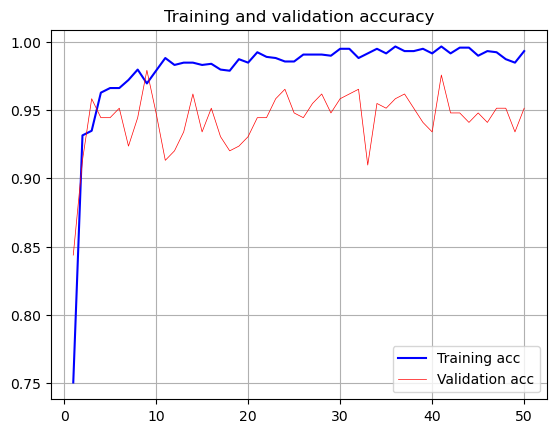

In [7]:
# model.load_weights(filepath='weights_save/weights_L_043_0.98.hdf5')

history = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=50,
    callbacks=my_callback
)

acc = history.history['accuracy']
epochs = range(1, len(acc) + 1)
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc', linewidth=0.5)
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.grid()
# 儲存acc學習曲線
# plt.savefig('./acc.png')
plt.show()
# 畫出loss學習曲線
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss', linewidth=0.5)
plt.title('Training and validation loss')
plt.legend(loc='upper right')
plt.grid()
# 儲存loss學習曲線
# plt.savefig('loss.png')
plt.show()

In [8]:
pred_train = model.evaluate(train_generator, verbose=0, steps=STEP_SIZE_TRAIN)
pred_val = model.evaluate(valid_generator, verbose=0, steps=STEP_SIZE_VALID)

print("Train loss:", pred_train[0])
print("Train accuracy:", pred_train[1])
print("Validation loss:", pred_val[0])
print("Validation accuracy:", pred_val[1])

Train loss: 0.0723571702837944
Train accuracy: 0.9923986196517944
Validation loss: 1.8540083169937134
Validation accuracy: 0.9409722089767456


In [9]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_directory(
    directory='test/',
    target_size=target_size,
    color_mode="rgb",
    class_mode='categorical',
    classes=label_classes,
)

for i, j in Counter(test_generator.classes).items():
    print(f"{label_classes[i]} with {j:3d} images")
print()

images = []
labels = []
predictions = []

for data, label in test_generator:
    
    prediction = np.argmax(model.predict(data), axis=1)
    predictions.extend(prediction)
    
    images.extend(data)
    
    labels.extend(np.argmax(label, axis=1))
    
    if (len(predictions) == test_generator.n):
        break

Found 7 images belonging to 11 classes.
森森 with   1 images
牛排 with   1 images
巧巧 with   1 images
小白 with   1 images
黑胖 with   1 images
乖狗 with   1 images
橘子 with   1 images

1/1 [==============================] - 1s 875ms/step


In [10]:
images = []
labels = []
predictions = []

for data, label in valid_generator:
    
    prediction = np.argmax(model.predict(data), axis=1)
    predictions.extend(prediction)
    
    images.extend(data)
    
    labels.extend(np.argmax(label, axis=1))
    
    if (len(predictions) == valid_generator.n):
        break

1/1 [==============================] - 0s 309ms/step


label=乖狗 | predict=黑胖


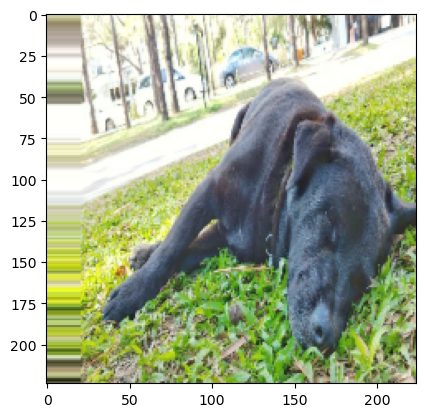

label=巧巧 | predict=小白


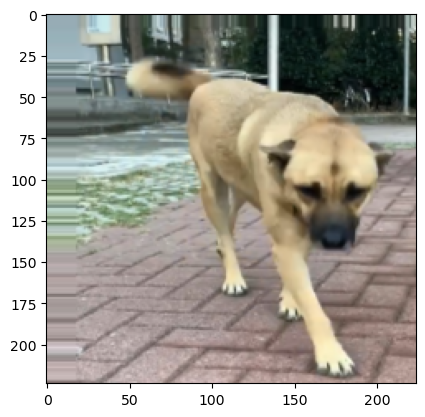

label=乖狗 | predict=花捲


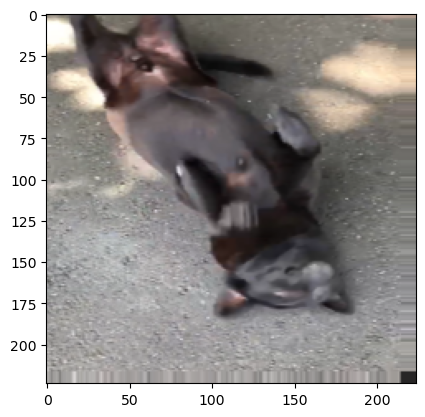

label=小白 | predict=森森


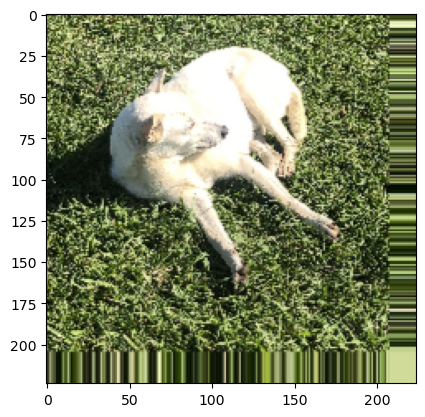

label=松鼠 | predict=森森


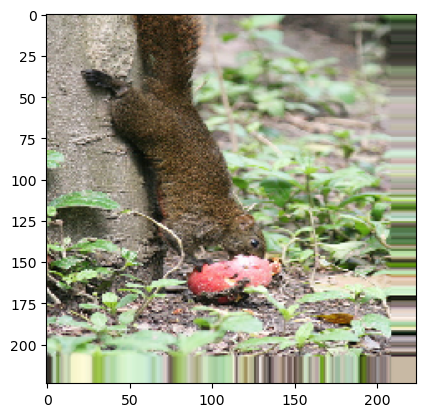

label=乖狗 | predict=黑胖


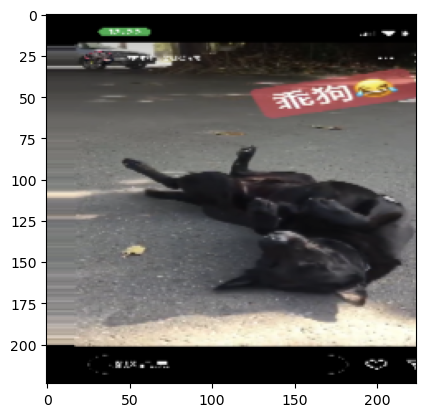

label=乖狗 | predict=黑胖


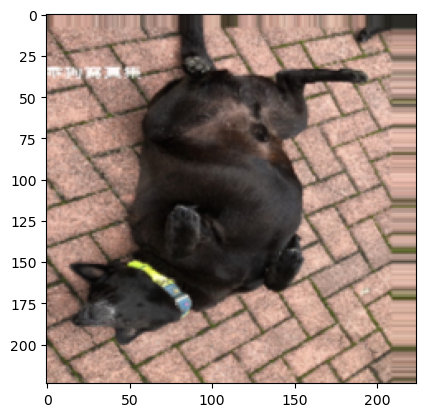

label=乖狗 | predict=黑胖


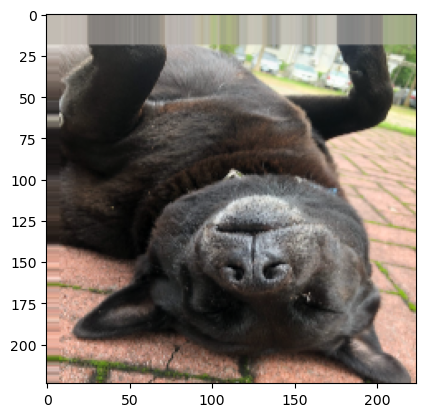

label=巧巧 | predict=森森


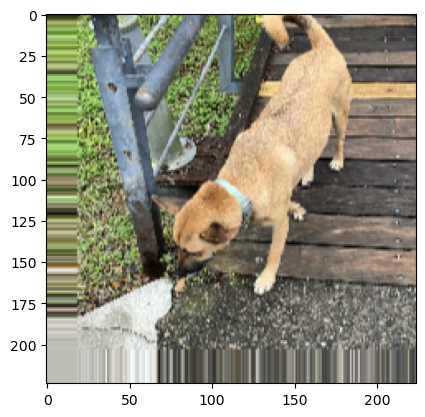

label=乖狗 | predict=黑胖


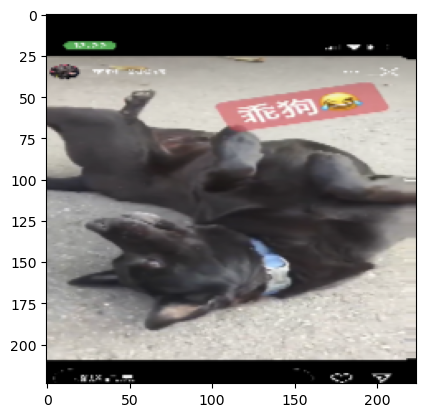

label=巧巧 | predict=森森


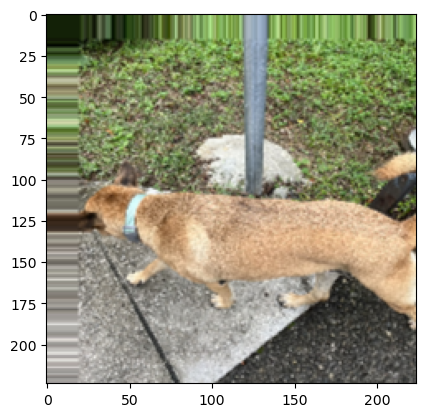

label=巧巧 | predict=花捲


label=小白 | predict=森森


label=松鼠 | predict=森森


label=巧巧 | predict=橘子


label=巧巧 | predict=森森


label=小白 | predict=森森


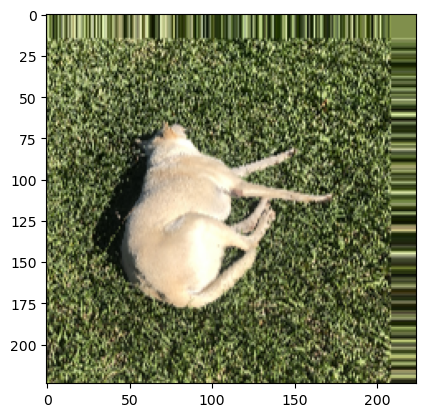

label=乖狗 | predict=橘子


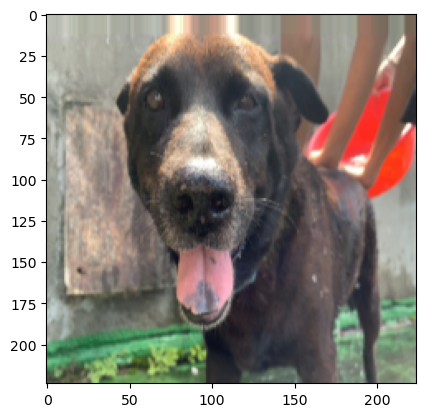

label=小白 | predict=森森


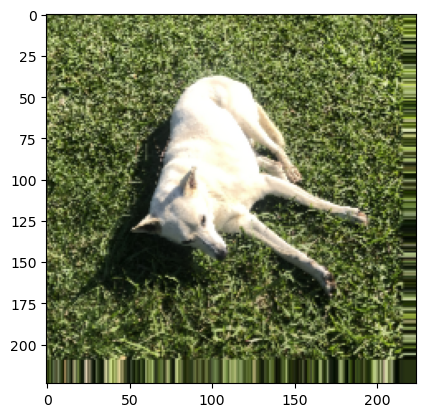

label=黑胖 | predict=乖狗


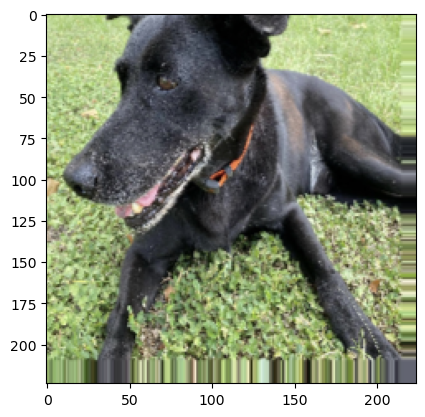

label=小白 | predict=森森


label=乖狗 | predict=橘子


label=巧巧 | predict=森森


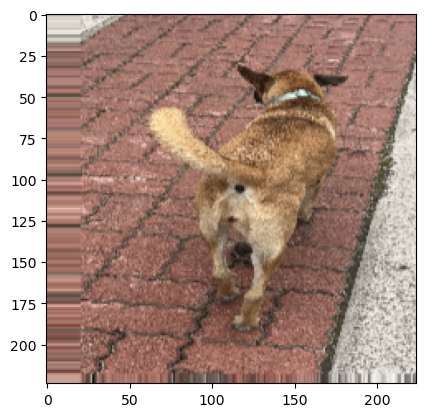

label=小白 | predict=森森


label=乖狗 | predict=黑胖


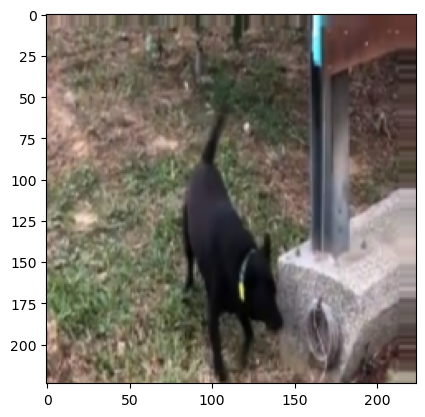

label=巧巧 | predict=橘子


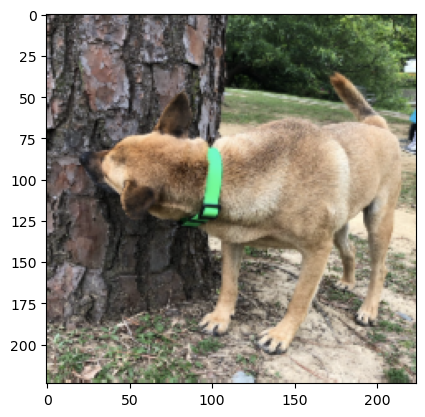

label=乖狗 | predict=黑胖


label=乖狗 | predict=花捲


In [11]:
# for i in range(test_generator.n):
    # print(f"label={label_classes[labels[i]]} | predict={label_classes[predictions[i]]}")
    # plt.imshow(images[i])
    # plt.show()
    
for i in range(valid_generator.n):
    if labels[i] != predictions[i]:
        print(f"label={label_classes[labels[i]]} | predict={label_classes[predictions[i]]}")
        plt.imshow(images[i])
        plt.show()

# Convert to tflite

In [12]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("model.tflite", "wb") as fh:
    fh.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\yuxun\AppData\Local\Temp\tmpsbvubxu0\assets


INFO:tensorflow:Assets written to: C:\Users\yuxun\AppData\Local\Temp\tmpsbvubxu0\assets
